![Logo](assets/logo.png)

Made by **Domonkos Nagy**

# $k$-armed bandit

Consider the following learning problem. You are faced repeatedly with a choice among
$k$ different options, or actions. After each choice you receive a numerical reward chosen
from a stationary probability distribution that depends on the action you selected. Your
objective is to maximize the expected total reward over some time period, for example,
over 1000 action selections, or time steps.

This is called the k-armed bandit problem. You can visualize this problem as having to
choose between $k$ slot machines (also known as one-armed bandits) at each time step,
each of which have a different probability distribution for rewards - that is where the name comes from.

The $k$-armed bandit problem illustrates one of the most important problems in reinforcement
learning: **exploration vs. exploitation**. At each time step $t$, the agent has to make a decision:
take the action with the highest expected reward according to the agent's current knowledge of the environment, 
or choose a different action to get a better estimation of the value of that action. The former is called an
*exploitation* step, because it exploits the current knowledge of the agent in order to obtain a high reward.
The latter is called an *exploration* step, since it involves trying out an action in order to have a better
estimation of its value, thereby exploring the environment.

This notebook introduces a few common strategies to tackle this problem, and puts them to the test by simulating
multiple test runs, and comparing the results.

In [1]:
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from tqdm import trange

The `Strategy` base class is used to implement startegies for action selection. An action is selected by the `act` method, and then the `update` method is used
to update the inner state after receiving a reward for the selected action. After an episode (a "run" consisting of $n$ steps, 1000 for example) is over, the `reset` method is called to reset the inner state of the class. The `name` propery is used get a name for the strategy in a visual representation.

In [2]:
class Strategy(ABC):

    def __init__(self, k):
        self.k = k

    @property
    @abstractmethod
    def name():
        pass

    @abstractmethod
    def act(self) -> int:
        pass

    @abstractmethod
    def update(self, action, reward):
        pass

    @abstractmethod
    def reset(self):
        pass

## $\varepsilon$-greedy action selection

With this method, the agent will select a random action with an $\varepsilon$ probability ($0 \le \varepsilon \le 1$), and act greedily (select the best action according to its knowledge) otherwise. The action values are calculated using the *sample-averages* method: the value of an action is the average of all the rewards received after taking that action.

In [3]:
class EpsilonGreedy(Strategy):

    def __init__(self, k, epsilon=0, initial=0):
        super().__init__(k)
        self.epsilon = epsilon
        self.initial = initial
        self.q_estimations = np.zeros(self.k) + self.initial
        self.selections = np.zeros(self.k)
        self.indices = np.arange(self.k)

    @property
    def name(self):
        name_str = ""
        if (self.epsilon == 0):
            name_str = "Greedy"
        else:
            name_str = f"$\\varepsilon$-greedy, $\\varepsilon = {self.epsilon}$"
        if (self.initial != 0):
            name_str += f", init: {self.initial}"
        return name_str

    def act(self):
        # exploring with an epsilon chance
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)
        # explointing otherwise
        else:
            q_max = np.max(self.q_estimations)
            return np.random.choice(np.where(self.q_estimations == q_max)[0])

    # sample-averages method for calculating action values
    def update(self, action, reward):
        self.selections[action] += 1
        # an incremental way of calculating the average
        # see pg. 31 of the Sutton-Barto book for more details
        self.q_estimations[action] += (reward - self.q_estimations[action]) / self.selections[action]

    def reset(self):
        self.q_estimations = np.zeros(self.k) + self.initial
        self.selections = np.zeros(self.k)

## Upper-Confidence-Bound (UCB) action selection

The UCB action selection method offers a way to select an action by taking both the estimated value, as well as the accuracy of those estimates into account.
The UCB formula looks like this:

$$ A_t := \underset{a}{\arg\max} \left[ Q_t(a) + c \frac{\ln(t)}{N_t(a)} \right] $$

Where $Q_t(a)$ denotes the value of action $a$ (calculated using the *sample-averages* method), $N_t(a)$ denotes the number of times that action $a$ has
been selected prior to time $t$, and the number $c > 0$ controls
the degree of exploration. If $N_t(a) = 0$, then $a$ is considered to be a maximizing action.

In [4]:
class UCB(Strategy):

    def __init__(self, k, c=1, initial=0):
        super().__init__(k)
        self.c = c
        self.initial = initial
        self.q_estimations = np.zeros(self.k) + self.initial
        self.selections = np.zeros(self.k)
        self.t = 0

    @property
    def name(self):
        return f"UCB, $c = {self.c}$"

    def act(self):
        UCB_estimations = self.q_estimations + self.c * np.sqrt(np.log(self.t + 1) / (self.selections + 1e-5))
        UCB_max = np.max(UCB_estimations)
        # numpy workaround for an argmax that break ties randomly
        return np.random.choice(np.where(UCB_estimations == UCB_max)[0])

    # sample-averages method for calculating action values
    def update(self, action, reward):
        self.t += 1
        self.selections[action] += 1
        # an incremental way of calculating the average
        # see pg. 31 of the Sutton-Barto book for more details
        self.q_estimations[action] += (reward - self.q_estimations[action]) / self.selections[action]

    def reset(self):
        self.t = 0
        self.q_estimations = np.zeros(self.k) + self.initial
        self.selections = np.zeros(self.k)

## Gradient bandit algorithms

Instead of estimating action values, this method learns a numerical *preference*, denoted $H_t(a)$ for each action. The preference is calculated using the *soft-max* function:

$$ \pi_t(a) := \Pr\{A_t = a\} := \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}} $$

Where here we have also introduced a useful new notation, $\pi_t(a)$, for the probability of
taking action $a$ at time $t$. Note that this function defines a probability distribution over the set of all actions. On each step, after selecting action $A_t$ and receiving the reward $R_t$, the
action preferences are updated by:

$$ H_{t+1}(A_t) := H_t(A_t) + \alpha(R_t - \bar{R}_t)\left(1 - \pi_t\left(A_t\right)\right),\quad \text{and} $$
$$ H_{t+1}(a) := H_t(a) + \alpha(R_t - \bar{R}_t) \pi_t(a),\quad \text{for all}\ a \neq A_t
$$

Where $\alpha > 0$ is a step-size parameter, and $\bar{R}_t \in \mathbb{R}$ is the average of all the rewards up
through and including time $t$. 
The $\bar{R}_t$ term serves as a
baseline with which the reward is compared.

In [5]:
class Gradient(Strategy):

    def __init__(self, k, alpha=0.1):
        super().__init__(k)
        self.alpha = alpha
        self.preferences = np.zeros(self.k)
        self.indices = np.arange(self.k)
        self.baseline = 0
        self.t = 0

    @property
    def name(self):
        return f"Gradient, $\\alpha = {self.alpha}$"

    def act(self):
        return np.random.choice(self.indices, p=self.softmax(self.preferences))

    def update(self, action, reward):
        self.t += 1
        # similar incremental calculation as the strategies above
        self.baseline += (reward - self.baseline) / self.t
        one_hot = np.zeros(self.k)
        one_hot[action] = 1
        self.preferences += self.alpha * (reward - self.baseline) * (one_hot - self.softmax(self.preferences))

    def reset(self):
        self.t = 0
        self.baseline = 0
        self.preferences = np.zeros(self.k)

    def softmax(self, x):
        return np.exp(x)/sum(np.exp(x))

## Simulating the problem

We test our strategies by trying them out in multiple runs, and then averaging out the received reward at each time step. After that, we plot the results to
compare the strategies.

In [6]:
K = 10  # number of actions


# action with some probability distribution
class Action:
    def __init__(self, distribution=None):
        self.mean = np.random.randn()
        self.distribution = distribution if distribution is not None else np.random.choice(["normal", "constant", "uniform"], p=[1, 0, 0])

    def get_reward(self):
        if self.distribution == "normal":
            return np.random.randn() + self.mean
        elif self.distribution == "uniform":
            return np.random.rand() + self.mean
        else:
            return self.mean


# simulating the k-armed bandit problem
def simulate(strategies, runs=2000, time=1000):
    rewards = np.zeros((len(strategies), runs, time))
    best_action_choices = np.zeros(rewards.shape)

    for i, strategy in enumerate(strategies):
        print(f"Simulating strategy {i + 1}/{len(strategies)}...")

        for r in trange(runs):
            # setting up actions with random probabilty distributions
            actions = [Action() for _ in range(K)]
            best_action = np.argmax([action.mean for action in actions])

            strategy.reset()

            for t in range(time):
                action = strategy.act()

                reward = actions[action].get_reward()
                rewards[i, r, t] = reward
                strategy.update(action, reward)

                if action == best_action:
                    best_action_choices[i, r, t] = 1

    # average of rewards received over all runs
    mean_rewards = rewards.mean(axis=1)
    # average of number of best action choices over all runs
    mean_best_action_choices = best_action_choices.mean(axis=1)

    return mean_rewards, mean_best_action_choices

In [7]:
# list of strategies to test
strategies = [
        EpsilonGreedy(K),
        EpsilonGreedy(K, epsilon=0.1),
        UCB(K, c=2),
        Gradient(K)
    ]

rewards, best_action_choices = simulate(strategies)

Simulating strategy 1/4...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.29it/s]


Simulating strategy 2/4...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:07<00:00, 29.63it/s]


Simulating strategy 3/4...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:35<00:00, 21.01it/s]


Simulating strategy 4/4...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:47<00:00, 18.62it/s]


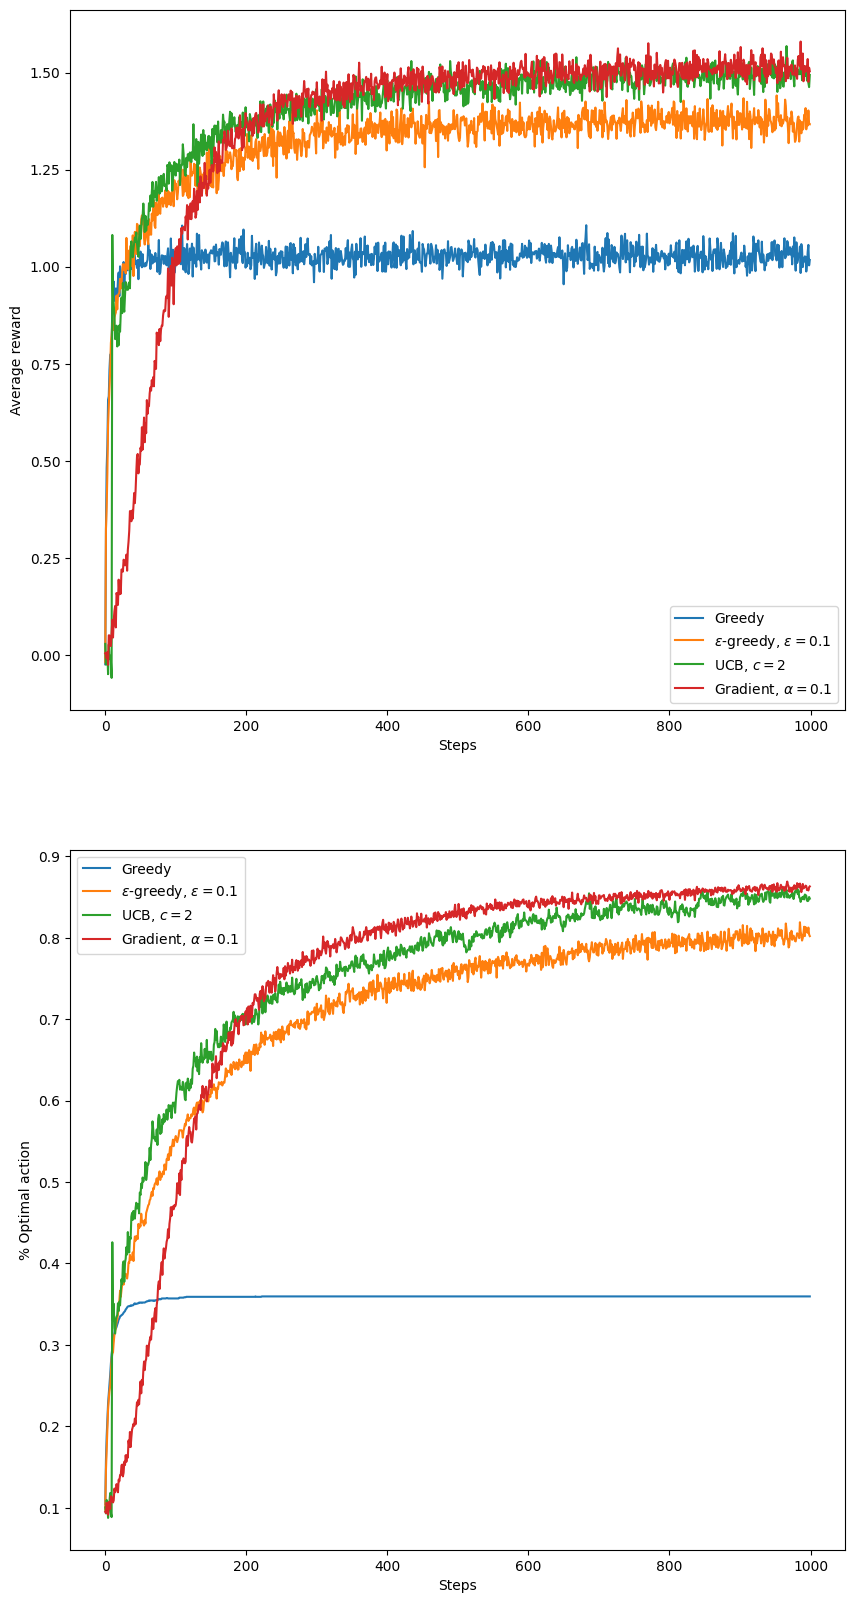

In [8]:
# plotting the results
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)

for strategy, reward in zip(strategies, rewards):
    plt.plot(reward, label=f"{strategy.name}")
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()

plt.subplot(2, 1, 2)
for strategy, choices in zip(strategies, best_action_choices):
    plt.plot(choices, label=f"{strategy.name}")
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()

plt.show()